# Proyek Klasifikasi Gambar: [Indonesian Batik Motifs (Corak App)]
- **Nama:** [Dhea Rachma Febiana]
- **Email:** [mc006d5x2410@student.devacademy.id]
- **ID Dicoding:** [MC006D5X2410]

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install opendatasets


In [2]:
import os, shutil
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import os
import json

import cv2
from PIL import Image
from skimage import io
from skimage.transform import resize
from skimage.util import img_as_ubyte
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.saved_model import save


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dhearachmaf","key":"b8509ad135aeb5d9abf03aadf754793c"}'}

In [4]:

os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
os.chmod("/root/.kaggle/kaggle.json", 600)


In [5]:
od.download("https://www.kaggle.com/datasets/ikjotsingh221/animal-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dhearachmaf
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ikjotsingh221/animal-dataset


In [ ]:
os.listdir("animal-dataset/dataset")

### Data Preprocessing

In [7]:
train_dir = "/content/animal-dataset/dataset/Training"
test_dir = "/content/animal-dataset/dataset/Testing"
combined_dir = "/content/animal-dataset/dataset/Combined"

os.makedirs(combined_dir, exist_ok=True)


for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)



In [8]:

print("Combined categories:", os.listdir("/content/animal-dataset/dataset/Combined"))


Combined categories: ['bears', 'elephants', 'rats', 'crows']


###Dataset Checking

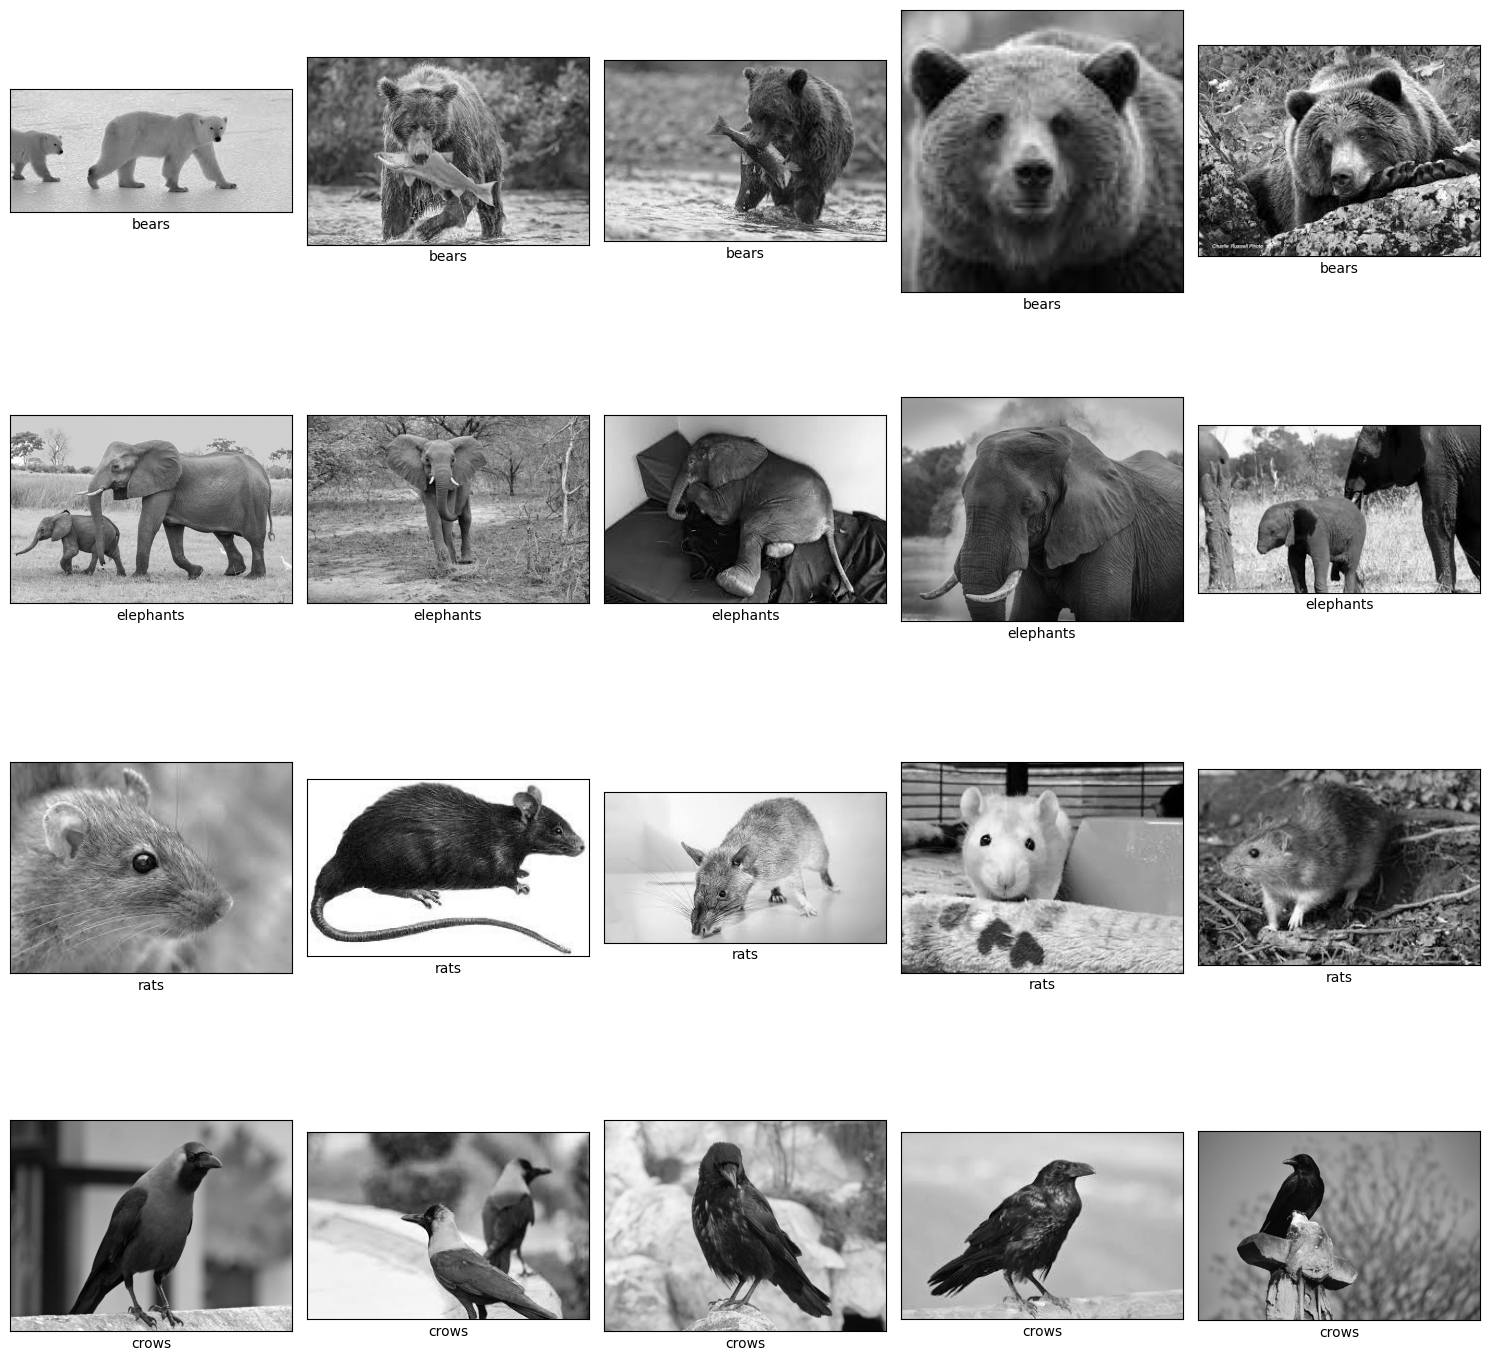

In [9]:
animal_image = {}
path = "/content/animal-dataset/dataset/"
path_sub = os.path.join(path, "Combined")
for i in os.listdir(path_sub):
    animal_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "/content/animal-dataset/dataset/Combined/"

fig, axs = plt.subplots(len(animal_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()



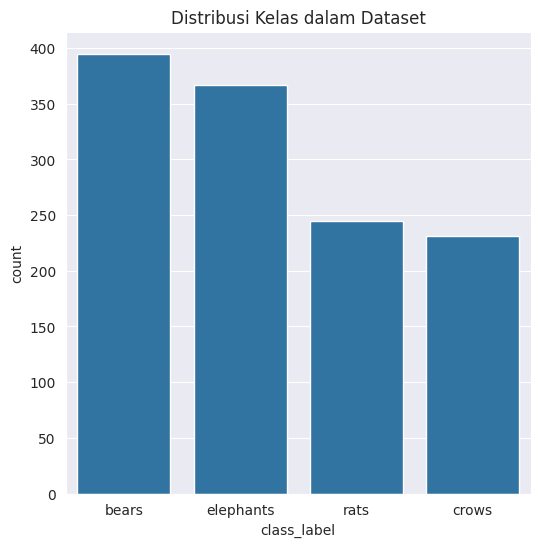

In [10]:

dataset_path = "/content/animal-dataset/dataset/Combined/"


file_paths, file_names, class_labels = [], [], []


for folder, _, filenames in os.walk(dataset_path):
    for file in filenames:
        file_paths.append(os.path.join(folder, file))
        class_labels.append(os.path.basename(folder))
        file_names.append(file)

df_distribution = pd.DataFrame({"file_path": file_paths, "file_name": file_names, "class_label": class_labels})


plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=df_distribution, x="class_label")
plt.title("Distribusi Kelas dalam Dataset")
plt.show()

###Data Augmentation

In [11]:
# backup_folder = "/content/animal-dataset"

# # Hapus seluruh folder dan isinya
# if os.path.exists(backup_folder):
#     shutil.rmtree(backup_folder)
#     print(f"✅ Folder '{backup_folder}' dan isinya telah dihapus.")
# else:
#     print(f"⚠️ Folder '{backup_folder}' tidak ditemukan, mungkin sudah terhapus.")

In [12]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [13]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "/content/animal-dataset/dataset/Combined/rats"
augmented_path = "/content/animal-dataset/dataset/Combined/rats"
images = []


for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))


images_to_generate = 150
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)


        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0
        transformation_count = random.randint(1, len(transformations))

        while n <= transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

In [14]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "/content/animal-dataset/dataset/Combined/crows"
augmented_path = "/content/animal-dataset/dataset/Combined/crows"
images = []


for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))


images_to_generate = 150
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)


        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0
        transformation_count = random.randint(1, len(transformations))

        while n <= transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

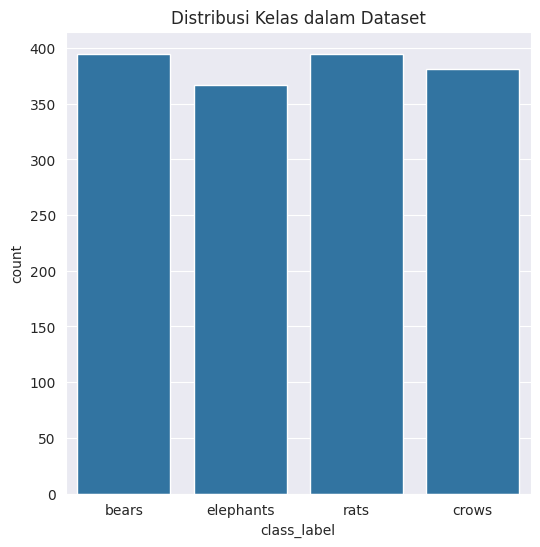

In [15]:
dataset_path = "/content/animal-dataset/dataset/Combined/"


file_paths, file_names, class_labels = [], [], []


for folder, _, filenames in os.walk(dataset_path):
    for file in filenames:
        file_paths.append(os.path.join(folder, file))
        class_labels.append(os.path.basename(folder))
        file_names.append(file)

df_distribution = pd.DataFrame({"file_path": file_paths, "file_name": file_names, "class_label": class_labels})


plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=df_distribution, x="class_label")
plt.title("Distribusi Kelas dalam Dataset")
plt.show()

### Data Splitting: Train & Test & Validation

In [16]:

mypath= '/content/animal-dataset/dataset/Combined/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

df.groupby(['labels']).size()

,0
labels,
bears,395
crows,381
elephants,367
rats,395


In [17]:
X= df['path']
y= df['labels']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [18]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [19]:
print('train size', len(df_tr))
print('test size', len(df_te))

train size 1230
test size 308


In [20]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)


print(df_all.groupby(['set', 'labels']).size(), '\n')

print(df_all.sample(5))



set    labels   
test   bears         80
       crows         86
       elephants     69
       rats          73
train  bears        315
       crows        295
       elephants    298
       rats         322
dtype: int64 

                                                   path labels    set
1241  /content/animal-dataset/dataset/Combined/crows...  crows   test
705   /content/animal-dataset/dataset/Combined/bears...  bears  train
658   /content/animal-dataset/dataset/Combined/rats/...   rats  train
643   /content/animal-dataset/dataset/Combined/rats/...   rats  train
1269  /content/animal-dataset/dataset/Combined/bears...  bears   test


In [21]:
datasource_path = "/content/animal-dataset/dataset/Combined/"
dataset_path = "dataset-final/"

for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['image'])

    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(target_dir, exist_ok=True)

    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)

    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

In [22]:
TRAIN_DIR = "dataset-final/train/"
TEST_DIR = "dataset-final/test/"

train_bears = os.path.join(TRAIN_DIR + '/bears')
train_elephants = os.path.join(TRAIN_DIR + '/elephants')
train_crows = os.path.join(TRAIN_DIR + '/crows')
train_rats = os.path.join(TRAIN_DIR + '/rats')

test_bears = os.path.join(TEST_DIR + '/bears')
test_elephants = os.path.join(TEST_DIR + '/elephants')
test_crows = os.path.join(TEST_DIR + '/crows')
test_rats = os.path.join(TEST_DIR + '/rats')


print("Total number of bears images in training set: ",len(os.listdir(train_bears)))
print("Total number of elephants images in training set: ",len(os.listdir(train_elephants)))
print("Total number of crows images in training set: ",len(os.listdir(train_crows)))
print("Total number of rats images in training set: ",len(os.listdir(train_rats)))
print()
print("Total number of bears images in training set: ",len(os.listdir(test_bears)))
print("Total number of elephants images in training set: ",len(os.listdir(test_elephants)))
print("Total number of crows images in training set: ",len(os.listdir(test_crows)))
print("Total number of rats images in training set: ",len(os.listdir(test_rats)))



Total number of bears images in training set:  315
Total number of elephants images in training set:  298
Total number of crows images in training set:  295
Total number of rats images in training set:  322

Total number of bears images in training set:  80
Total number of elephants images in training set:  69
Total number of crows images in training set:  86
Total number of rats images in training set:  73


In [24]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 985 images belonging to 4 classes.
Found 245 images belonging to 4 classes.
Found 308 images belonging to 4 classes.


## Modelling

In [25]:

model_1 = Sequential()


# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())

model_1.add(Dense(128, activation = 'relu'))

model_1.add(Dropout(0.5))

model_1.add(Dense(64, activation = 'relu'))

model_1.add(Dropout(0.3))

# Output Layer untuk 4 classes
model_1.add(Dense(4, activation='softmax'))



model_1.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,076 (5.35 MB)

 Trainable params: 1,402,884 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [26]:

count_bears, count_elephants, count_crows, count_rats = len(os.listdir(train_bears)), len(os.listdir(train_elephants)), len(os.listdir(train_crows)), len(os.listdir(train_rats))


weight_bears = (1 / count_bears) * (count_bears + count_elephants + count_crows + count_rats) / 4.0
weight_elephants = (1 / count_elephants) * (count_elephants + count_bears + count_crows + count_rats) / 4.0
weight_crows = (1 / count_crows) * (count_crows + count_bears + count_elephants + count_rats) / 4.0
weight_rats = (1 / count_rats) * (count_rats + count_bears + count_elephants + count_crows) / 4.0

class_weights = {
    0: weight_bears,
    1: weight_elephants,
    2: weight_crows,
    3: weight_rats
}

%time

history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight=class_weights)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.3229 - loss: 4.6078 - val_accuracy: 0.2612 - val_loss: 2.7645
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4221 - loss: 2.0672 - val_accuracy: 0.2612 - val_loss: 2.6220
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.4170 - loss: 1.8303 - val_accuracy: 0.2327 - val_loss: 2.8097
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5066 - loss: 1.4064 - val_accuracy: 0.2612 - val_loss: 6.5921
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5481 - loss: 1.3105 - val_accuracy: 0.2612 - val_loss: 6.4066
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5693 - loss: 1.1467 - val_accuracy: 0.2816 - val_loss: 4.9740
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.6341 - loss: 1.0368 - val_accuracy: 0.3347 - val_loss: 5.0686
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6865 - loss: 0.9558 - val_accuracy: 0.2816 - val_loss: 

## Evaluasi dan Visualisasi

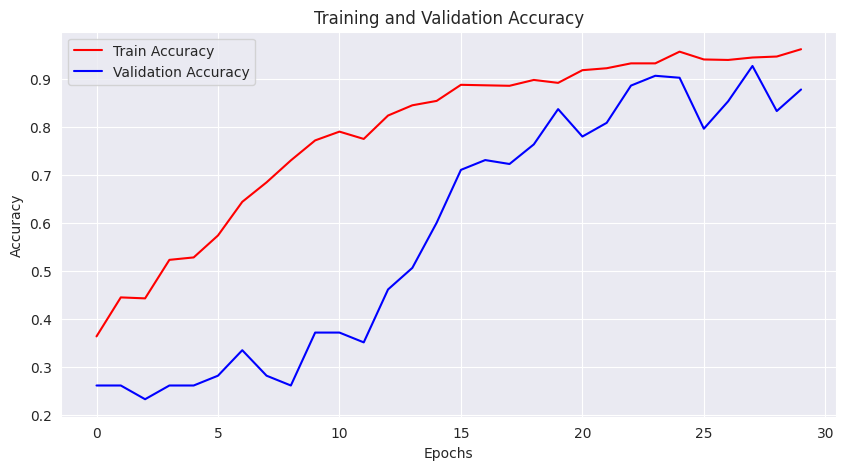

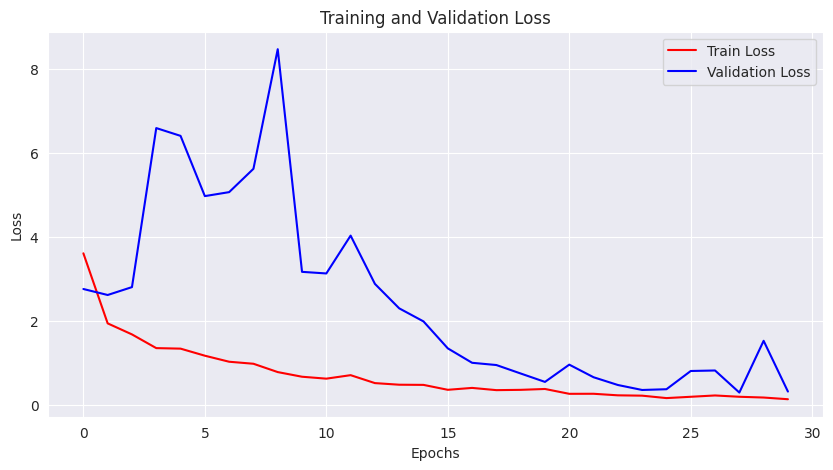

In [27]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi Training vs Validation
plt.figure(figsize=(10,5))
plt.plot(epochs, acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot Loss Training vs Validation
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

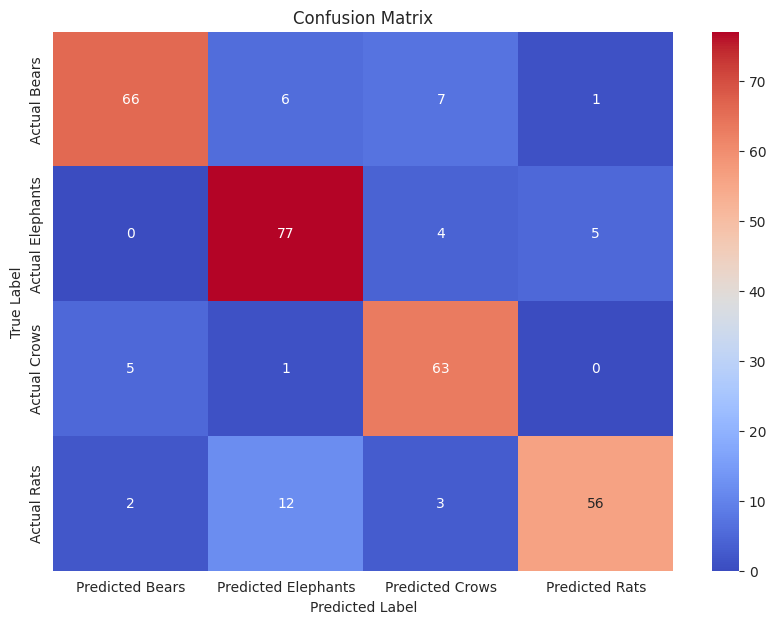


🔎 Classification Report:

              precision    recall  f1-score   support

       Bears     0.9041    0.8250    0.8627        80
   Elephants     0.8021    0.8953    0.8462        86
       Crows     0.8182    0.9130    0.8630        69
        Rats     0.9032    0.7671    0.8296        73

    accuracy                         0.8506       308
   macro avg     0.8569    0.8501    0.8504       308
weighted avg     0.8562    0.8506    0.8503       308



In [28]:
test_generator.reset()


predictions = model_1.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)


true_labels = test_generator.classes

# Buat Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
conf_df = pd.DataFrame(conf_matrix,
    index=["Actual Bears", "Actual Elephants", "Actual Crows", "Actual Rats"],
    columns=["Predicted Bears", "Predicted Elephants", "Predicted Crows", "Predicted Rats"])

# Plot heatmap Confusion Matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="coolwarm")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


print("\n🔎 Classification Report:\n")
print(classification_report(true_labels, predicted_classes,
    target_names=['Bears', 'Elephants', 'Crows', 'Rats'], digits=4))

## Konversi Model

In [29]:
save_path = 'saved_model/'
tf.saved_model.save(model_1, save_path)

print(f"✅ Model berhasil disimpan di {save_path}")



✅ Model berhasil disimpan di saved_model/


In [30]:
save_path = 'saved_model/'
print("Isi folder saved_model:", os.listdir(save_path))


Isi folder saved_model: ['saved_model.pb', 'variables', 'assets', 'fingerprint.pb']


In [31]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/')
tflite_model = converter.convert()


os.makedirs('tflite', exist_ok=True)


with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan label
labels = ["bears", "elephant", "crows", "rats"]
with open('tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

In [34]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [35]:
# Mengonversi model TensorFlow yang disimpan sebagai SavedModel (format standar untuk deployment) ke format tfjs_graph_model
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    saved_model/ tfjs_model/


2025-05-10 09:43:56.849777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746870236.881894    3919 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746870236.902232    3919 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-10 09:44:08.401409: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746870248.401620    3919 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [39]:
# Buat arsip ZIP dari folder tfjs_model
shutil.make_archive("tfjs_model", "zip", "tfjs_model")

# Unduh file ZIP menggunakan Google Colab
from google.colab import files
files.download("tfjs_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:

!pip freeze > /content/requirements.txt


from google.colab import files
files.download("/content/requirements.txt")

print("✅ File requirements.txt telah dibuat dan siap diunduh!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ File requirements.txt telah dibuat dan siap diunduh!


## Inference (Optional)